CPU or GPU? :  cpu(0)
(1249, 8192)
Peak sampling point at 7371th (0.90s).
总波形数目： (1249,)
训练集波形数目： 600
测试集波形数目： 649


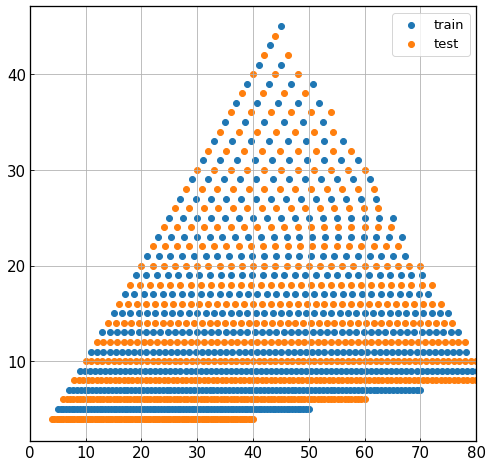

In [1]:
import sys, os
sys.path.append(os.path.abspath(''))   # 把当前目录设为引用模块的地址之一

from utils import *
from data_utils import *
from models.solver_cnn import *
from models.ConvNet import *

from data_utils import *
from data_noise import *

import mxnet as mx
import mxnet.ndarray as nd

import numpy as np
import pandas as pd
from itertools import product, permutations

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

plt.rcParams['axes.linewidth'] = 1.3
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 13

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# Easily Profile Python Code in Jupyter
# install conda install line_profiler or pip install line-profiler
# see http://mortada.net/easily-profile-python-code-in-jupyter.html
%load_ext line_profiler

test_ctx()

#############################
GW_address = './data/'

data = pd.DataFrame(np.load(GW_address+'GW_H1.npy'), index=np.load(GW_address+'GW_H1_index.npy'))
print(data.shape)
peak_samppoint = data.values.argmax(axis=1)
peak_samppoint = int(peak_samppoint.sum() / peak_samppoint.shape[0])
peak_time = peak_samppoint/data.shape[-1]
peak_time = float('{:.2f}'.format(peak_time))
print('Peak sampling point at %dth (%.2fs).' %(peak_samppoint, peak_time))
data.head()
# 波形数据


print('总波形数目：', data.index.shape)
train_masses = [(float(masses.split('|')[0]), float(masses.split('|')[1])) for masses in data.index if float(masses.split('|')[0]) % 2 != 0]
test_masses = [(float(masses.split('|')[0]), float(masses.split('|')[1])) for masses in data.index if float(masses.split('|')[0]) % 2 == 0]
print('训练集波形数目：', len(train_masses))
print('测试集波形数目：', len(test_masses))

train_m1, train_m2 = [ m[0] for m in train_masses],  [ m[1] for m in train_masses]
test_m1, test_m2 = [ m[0] for m in test_masses],  [ m[1] for m in test_masses]
plt.figure(figsize= (8,8))
plt.scatter(train_m2, train_m1, label='train')
plt.scatter(test_m2, test_m1, label = 'test')
plt.grid()
plt.legend()
plt.xlim(0,80)
# plt.title('训练集和测试集的波形在质量上的分布')
plt.show()

# 做好训练集和测试集的分割~

test_masses = [masses for masses in data.index if float(masses.split('|')[0]) % 2 == 0]
train_masses = [masses for masses in data.index if float(masses.split('|')[0]) % 2 != 0]
train_data = data.loc[train_masses]
test_data = data.loc[test_masses]

In [ ]:
def ppp(data, fLow, fHigh, fs, shuffle = True):

    if shuffle:
        data, shift_list = shuffle_data_nd(nd.array(data, ctx=mx.cpu()),peak_samppoint, peak_time, 5)
        data = pd.DataFrame(data.asnumpy())

    b = nd.array(pre_fir(fLow=fLow, fHigh=fHigh, fs = fs).reshape((-1,1)), ctx=ctx)
    pp = pre_fftfilt(b, shape = data.shape, nfft=None)
    vline_list = []
    mf_list = []
    for snr in (np.array([0.01]+np.arange(0.05,1.04,0.05).tolist())):
        n = GenNoise_matlab_nd(shape = data.shape, params=pp)
        sigma_ = data.max(axis=1) / float(snr) / n.asnumpy().std(axis=1 , dtype = 'float64')
        signal_ = data.div(sigma_, axis=0)
        sim = signal_ + n.asnumpy()
        mf = SNR_MF(sim, n.asnumpy(), signal_)
#         print(mf.mean())
        plt.hist(mf , bins = 50, alpha = 0.6)
        plt.vlines(x = np.array(mf).mean(), ymin=0, ymax=90, alpha = 0.8)
        mf_list.append(mf)
        vline_list.append(np.array(mf).mean())
        print(snr)
    plt.show()
    print(vline_list)
    return mf_list

In [408]:
random_peak = np.concatenate((Normolise(data).values[300][600:], np.array([0,]*600)) ,)

(8192,)

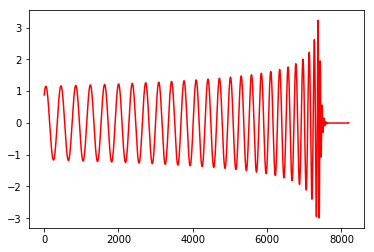

In [492]:
# plt.figure(figsize=(20,10))
random_peak = np.concatenate((Normolise(data).values[600][1:], np.array([0,]*1)) ,)
# plt.plot(Normolise(data).values[100], 'r')
plt.plot(random_peak, 'r')
plt.savefig('./images/waveform_dataflow0.png',dpi=300, bbox_inches='tight',transparent=False)

/Users/Herb/github/Python4GW/data_noise.py:204: ComplexWarning: Casting complex values to real discards the imaginary part
  y[istart-1:yend,:] = y[istart-1:yend,:] + Y[:(yend-istart+1),:]


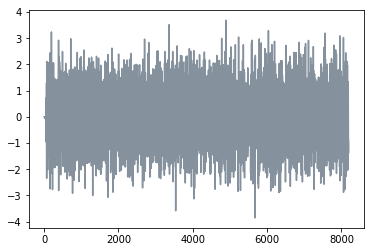

In [494]:
# plt.figure(figsize=(20,10))
noise = Normolise([GenNoise_matlab(nDataSamples=8192)])[0]
# plt.plot(noise)
# plt.plot(noise+ Normolise(data).values[300]/Normolise(data).values[300].max(),alpha=0.6, color='#34495e')
# plt.plot(Normolise(data).values[300]/Normolise(data).values[300].max(), 'r')
plt.plot(noise,alpha=0.6, color='#34495e')
# plt.plot(noise+ random_peak/random_peak.max(),alpha=0.6, color='#34495e')
# plt.plot(random_peak/random_peak.max(), 'r')
plt.savefig('./images/noise_dataflow1.png', dpi=300, bbox_inches='tight',transparent=False)

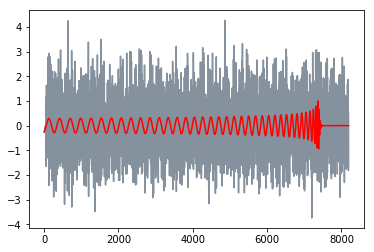

In [435]:
plt.plot(noise+ random_peak/random_peak.max(),alpha=0.6, color='#34495e')
plt.plot(random_peak/random_peak.max(), 'r')

In [463]:
def Fine_tune(name, value):
    default = {'default':{'drop_prob': 0,
                          'fc_params_act_type': ({'hidden_dim':(64,)},
                                                 {'act_type': ('relu',)*4}),
                          'pool_type_kernel': (('avg','avg','avg',), 
                                               ((1,16), (1,16), (1,16),)),
                          'dialute': 1,
                          'num_filter': (16,32,64) }}
    df = pd.DataFrame(default)
    df.drop([name], inplace=True)
    params_list = []
    for i,j in product(value, dict(df).values()):
        dd = dict(j)
        dd[name] = i
        dd['hidden_dim'] = dd['fc_params_act_type'][0]
        dd['act_type'] = dd.pop('fc_params_act_type')[1]
        dd['pool_type'] = dd['pool_type_kernel'][0]
        dd['pool_kernel'] = dd.pop('pool_type_kernel')[1]        
        params_list.append(dd)
    return params_list
def test(diedai):
    for hyperparam in diedai:
        hidden_dim = hyperparam['hidden_dim']
        drop_prob = hyperparam['drop_prob']
        num_filter = hyperparam['num_filter']
        act_type= hyperparam['act_type']
        dialute= hyperparam['dialute']
        pool_kernel = hyperparam['pool_kernel']
        pool_type = hyperparam['pool_type']
        print()
        print('hidden_dim |', hidden_dim)
        print('drop_prob |' , drop_prob)
        print('num_filter |', num_filter)
        print('act_type |' , act_type)
        print('dialute |', dialute)
        print('pool_kernel |', pool_kernel)
        print('pool_type |', pool_type)

In [470]:
for j,i in zip(['1','3'], Fine_tune('fc_params_act_type', [({'hidden_dim': (64,)}, {'act_type': ('elu',)*4}),
                                          ({'hidden_dim': (64,)}, {'act_type': ('relu',)*4})]) ):
    print(j,i)

1 {'dialute': 1, 'drop_prob': 0, 'num_filter': (16, 32, 64), 'hidden_dim': {'hidden_dim': (64,)}, 'act_type': {'act_type': ('elu', 'elu', 'elu', 'elu')}, 'pool_type': ('avg', 'avg', 'avg'), 'pool_kernel': ((1, 16), (1, 16), (1, 16))}
3 {'dialute': 1, 'drop_prob': 0, 'num_filter': (16, 32, 64), 'hidden_dim': {'hidden_dim': (64,)}, 'act_type': {'act_type': ('relu', 'relu', 'relu', 'relu')}, 'pool_type': ('avg', 'avg', 'avg'), 'pool_kernel': ((1, 16), (1, 16), (1, 16))}


In [503]:
!mv /Users/Herb/Downloads/eta\=-0.1 /Users/Herb/Downloads/eta_m0_1.csv

In [527]:
!mv /Users/Herb/Downloads/eta\=3 /Users/Herb/Downloads/eta_3.csv

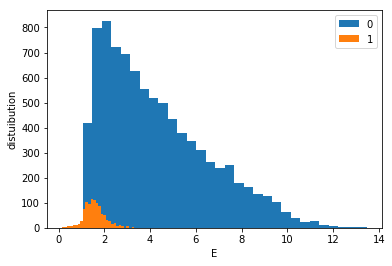

In [540]:
import matplotlib.pyplot as plt
import seaborn as sns

file_address = '/Users/Herb/Downloads/eta_3.csv'
df = pd.read_csv(file_address, header=1,delim_whitespace=True)
plt.hist(df[df.m == 0].E, bins=30, label = '0')
plt.hist(df[df.m == 1].E, bins=30, label= '1')
plt.xlabel('E')
plt.ylabel('distuibution')
plt.legend()

## Statistics of $\rho_{MF}$ for fixed $\rho_{amp}$. 

In each color, we fix a given $\rho_{amp}$, which is shown in the legend, and generate randomly data d = n + h, in which 5-fold expansion for h by peak-location randomization. For each simulated data we compute the corresponding $\rho_{MF}$ and count the numbers for each $\rho_{MF}$ range.

Save or not? (y/n)y
Saved in ./images/distributionsnr_mf_vs_snr_amp.pdf


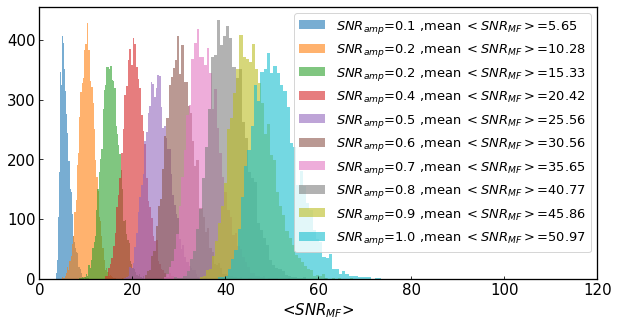

In [3]:
# snr_mf = ppp(data=data, fLow=9, fHigh=9000, fs = 8192)
# np.save('./images/data/snr_mf_5fold', snr_mf)
snr_mf = np.load('./images/data/snr_mf_5fold.npy')

plt.figure(figsize=(10,5))
for i, snr in enumerate(np.array([0.01]+np.arange(0.05,1.04,0.05).tolist())[1::2]):
    plt.hist(snr_mf[i*2+2] , bins = 50, alpha = 0.6, label = '$SNR_{amp}$=%.1f ,mean $<SNR_{MF}>$=%.2f' %(snr, np.array(snr_mf[i*2+2]).mean()))
plt.xlabel('<$SNR_{MF}$>')
plt.legend(loc='upper right')
plt.xlim(xmax=120)
if input('Save or not? (y/n)') == 'y':
    save_address = './images/'
    plt.savefig(save_address + 'distribution_snr_mf_vs_snr_amp.pdf', dpi = 300, bbox_inches = 'tight')
    print('Saved in '+save_address+'distributionsnr_mf_vs_snr_amp.pdf')
else:
    pass
plt.show()

## SNR $\langle\rho_{MP}\rangle$ v.s $\rho_{amp}$

Relation between the averaged matched filtering SNR $\langle\rho_{MP}\rangle$ and $\rho_{amp}$ based on the statistics investigation (above Fig). Approximated linear relation is also shown in the plot.

Save or not? (y/n)y
Saved in ./images/snr_mf_vs_snr_amp.eps


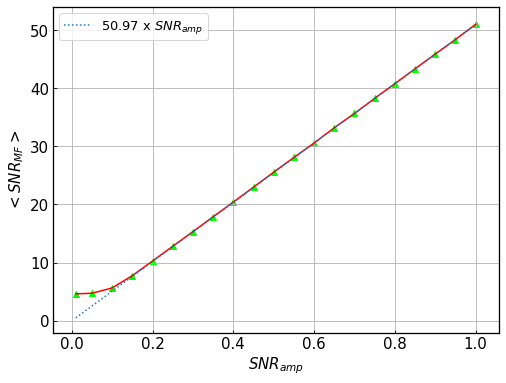

In [4]:
plt.figure(figsize=(8,6))
x = np.array([0.01]+np.arange(0.05,1.04,0.05).tolist())

snr_mf = np.load('./images/data/snr_mf_5fold.npy')
snr_mf_mean = snr_mf.mean(axis=1)

plt.plot(x, snr_mf_mean, 'r-')
plt.plot(x, x*snr_mf_mean[-1], ls='dotted', label = '%.2f x $SNR_{amp}$' %snr_mf_mean[-1])
plt.scatter(np.array([0.01]+np.arange(0.05,1.04,0.05).tolist()), snr_mf_mean,marker='^', c='lime')
plt.xlabel('$SNR_{amp}$')
plt.ylabel('$<SNR_{MF}>$')
plt.legend()
plt.grid()
if input('Save or not? (y/n)') == 'y':
    save_address = './images/'
    plt.savefig(save_address + 'snr_mf_vs_snr_amp.eps', dpi = 300, bbox_inches = 'tight')
    print('Saved in '+save_address+'snr_mf_vs_snr_amp.eps')
else:
    pass
plt.show()

## ROC comparison among different $\rho_{MF}$ of training data

Automatically created module for IPython interactive environment
Save or not? (y/n)y
Saved in ./images/ROC_comparison_training.eps


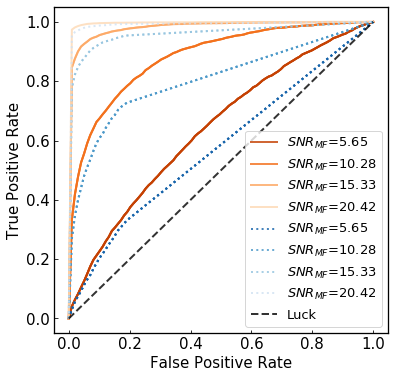

In [5]:
# https://stackoverflow.com/questions/41806066/families-of-curves-with-different-seaborn-palettes-in-one-plot
print(__doc__)
tpr_OURs_new2 = np.load('./AUC_data/tpr_OURs_new2.npy')
fpr_OURs_new2 = np.load('./AUC_data/fpr_OURs_new2.npy')

tpr_OURs_2localnoise10 = np.load('./AUC_data/tpr_OURs_2localnoise10.npy')
fpr_OURs_2localnoise10 = np.load('./AUC_data/fpr_OURs_2localnoise10.npy')

snr_mf = np.load('./images/data/snr_mf_5fold.npy')
snr_mf_mean = snr_mf.mean(axis=1)

from scipy import interp
mean_fpr = np.linspace(0, 1, 100)
snr_training = 0
snr_testings = 4


# plt.figure(figsize=(10,10))
fig, ax = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(6)
mean_tpr_list = []
index_list = []
for snr_testing in range(0,snr_testings):
    tprs = []
    for i in range(5):
        tprs.append(interp(mean_fpr, 
                           fpr_OURs_new2[snr_training,snr_testing][i], 
                           tpr_OURs_new2[snr_training,snr_testing][i]).tolist())
        tprs[-1][0] = 0.0
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_tpr_list.append(mean_tpr.tolist())
    index_list.append('%s' %['$SNR_{MF}$=%.2f' %snr for snr in snr_mf_mean[2::2]][snr_testing])
#     plt.plot(mean_fpr, mean_tpr, lw=2, alpha=.8,
#              label = '%s' %['$SNR_{MF}$=%.2f' %snr for snr in snr_mf_mean[2::2]][snr_testing])
    df = pd.DataFrame(mean_tpr_list, index = index_list)
    df.T.plot(x=mean_fpr, ax=ax, color=sns.color_palette('Oranges_r', snr_testings), lw=2, alpha=.8)
    
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
#     ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2)

mean_tpr_list = []
index_list = []    
for snr_testing in range(0,snr_testings):
    tprs = []
    for i in range(5):
        tprs.append(interp(mean_fpr, 
                           fpr_OURs_2localnoise10[snr_training,snr_testing][i], 
                           tpr_OURs_2localnoise10[snr_training,snr_testing][i]).tolist())
        tprs[-1][0] = 0.0
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_tpr_list.append(mean_tpr.tolist())
    index_list.append('%s' %['$SNR_{MF}$=%.2f' %snr for snr in snr_mf_mean[2::2]][snr_testing])
#     plt.plot(mean_fpr, mean_tpr, lw=2, alpha=.8,
#              label = '%s' %['$SNR_{MF}$=%.2f' %snr for snr in snr_mf_mean[2::2]][snr_testing])
    df = pd.DataFrame(mean_tpr_list, index = index_list)
    df.T.plot(x=mean_fpr, ax=ax, color=sns.color_palette('Blues_r', snr_testings),linestyle=':' ,lw=2, alpha=.8)  

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
#     ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k',
         label='Luck', alpha=.8)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic example')
plt.legend(ncol = 1, loc="lower right")

if input('Save or not? (y/n)') == 'y':
    save_address = './images/'
    plt.savefig(save_address + 'ROC_comparison_training.eps', dpi = 300, bbox_inches = 'tight')
    plt.savefig(save_address + 'ROC_comparison_training.pdf', dpi = 300, bbox_inches = 'tight')
    print('Saved in '+save_address+'ROC_comparison_training.eps')
else:
    pass

plt.show()

## AUC comparison among different $\rho_{MF}$ of training data

In [6]:
# AUC_PRL = np.load('./AUC_data/AUC_PRL_new2.npy')
# AUC_PLB = np.load('./AUC_data/AUC_PLB_new2.npy')
AUC_OURs = np.load('./AUC_data/AUC_OURs_new2.npy')
# AUC_OURs_2localnoise1 = np.load('./AUC_data/AUC_OURs_2localnoise1.npy')
# AUC_OURs_2localnoise5 = np.load('./AUC_data/AUC_OURs_2localnoise5.npy')
AUC_OURs_2localnoise10 = np.load('./AUC_data/AUC_OURs_2localnoise10.npy')
# AUC_OURs_new3_localnoise = np.load('./AUC_data/AUC_OURs_new3_localnoise.npy')

Save or not? (y/n)y
Saved in ./images/AUC_comparison_training.eps


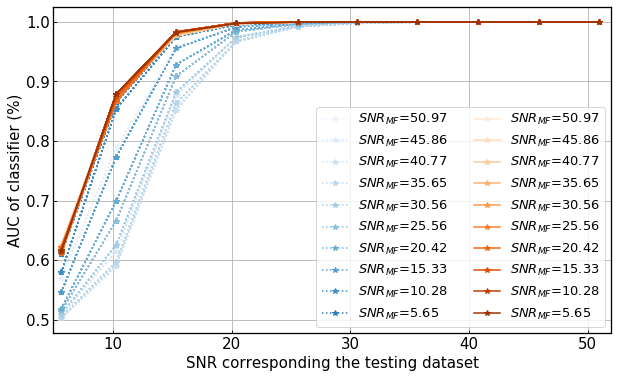

In [7]:
# https://stackoverflow.com/questions/41806066/families-of-curves-with-different-seaborn-palettes-in-one-plot
snr_mf = np.load('./images/data/snr_mf_5fold.npy')
snr_mf_mean = snr_mf.mean(axis=1)

fig, ax = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(10)
df = pd.DataFrame(AUC_OURs_2localnoise10.min(axis=2), index = ['$SNR_{MF}$=%.2f' %snr for snr in snr_mf_mean[2::2]][::-1], 
                  columns=snr_mf_mean[2::2])
for i in range(AUC_OURs_2localnoise10.shape[0]):
    df.T.plot(marker= '*',linestyle=':', ax=ax, color=sns.color_palette('Blues', 13), alpha = 1)    

df = pd.DataFrame(AUC_OURs.min(axis=2), index = ['$SNR_{MF}$=%.2f' %snr for snr in snr_mf_mean[2::2]][::-1], 
                  columns=snr_mf_mean[2::2])    
for i in range(AUC_OURs.shape[0]):
    df.T.plot(marker= '*', ax=ax, color=sns.color_palette("Oranges", 10), alpha = 1)    
ax.legend(ncol=2, loc='best')
ax.set_xlim(5, 52)
ax.set_ylabel('AUC of classifier (%)')
ax.set_xlabel('SNR corresponding the testing dataset')
ax.grid()
if input('Save or not? (y/n)') == 'y':
    save_address = './images/'
    plt.savefig(save_address + 'AUC_comparison_training.eps', dpi = 300, bbox_inches = 'tight')
    plt.savefig(save_address + 'AUC_comparison_training.pdf', dpi = 300, bbox_inches = 'tight')
    print('Saved in '+save_address+'AUC_comparison_training.eps')
else:
    pass
plt.show()

## Asymptotical accuracy of signal recognizing 

The relation between the asymptotical accuracy of signal recognizing and the SNR $\rho_{MF}$ of the training / testing data.


In [8]:
acc_training_list =  []
acc_testing_list =  []

acc_training_list_finitenoise =  []
acc_testing_list_finitenoise =  []
for i in range(1,11):
    os.system('ls -a ./pretrained_models/OURs_new/snr_%s_best* > test.txt' %(i*10))
    params_adds = pd.read_csv('./test.txt', header=None)
    os.system('rm test.txt')
    where_stop = params_adds[0].map(lambda x: int(x.split('_')[6].split('@')[1]))
    acc_training_list.append(nd.load('./pretrained_models/OURs_new/snr_%s_info.pkl' %(i*10))['train_acc_history'].asnumpy()[where_stop-1][0].tolist())
    acc_testing_list.append(nd.load('./pretrained_models/OURs_new/snr_%s_info.pkl' %(i*10))['test_acc_history'].asnumpy()[where_stop-1][0].tolist())
    
    os.system('ls -a ./pretrained_models/OURs_2finitenoise10/snr_%s_best* > test.txt' %(i*10))
    params_adds = pd.read_csv('./test.txt', header=None)
    os.system('rm test.txt')
    where_stop = params_adds[0].map(lambda x: int(x.split('_')[6].split('@')[1]))
    acc_training_list_finitenoise.append(nd.load('./pretrained_models/OURs_2finitenoise10/snr_%s_info.pkl' %(i*10))['train_acc_history'].asnumpy()[where_stop-1][0].tolist())
    acc_testing_list_finitenoise.append(nd.load('./pretrained_models/OURs_2finitenoise10/snr_%s_info.pkl' %(i*10))['test_acc_history'].asnumpy()[where_stop-1][0].tolist())

Save or not? (y/n)y
Saved in ./images/asymptotical_acc.eps


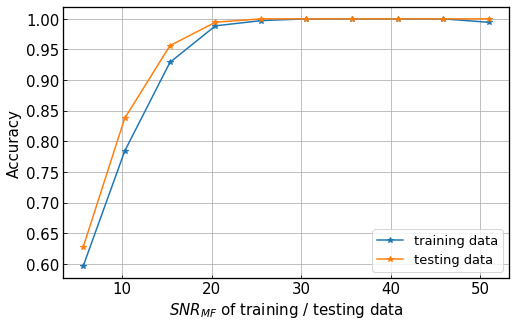

In [9]:
snr_mf = np.load('./images/data/snr_mf_5fold.npy')
snr_mf_mean = snr_mf.mean(axis=1)

plt.figure(figsize=(8,5))
plt.plot(snr_mf_mean[2::2], acc_training_list, '*-', label = 'training data')
plt.plot(snr_mf_mean[2::2], acc_testing_list, '*-', label = 'testing data')
plt.xlabel('$SNR_{MF}$ of training / testing data')
plt.ylabel('Accuracy')
plt.grid()
plt.legend(loc='lower right')

if input('Save or not? (y/n)') == 'y':
    save_address = './images/'
    plt.savefig(save_address + 'asymptotical_acc.eps', dpi = 300, bbox_inches = 'tight')
    plt.savefig(save_address + 'asymptotical_acc.pdf', dpi = 300, bbox_inches = 'tight')
    print('Saved in '+save_address+'asymptotical_acc.eps')
else:
    pass

plt.show()


# plt.plot(acc_training_list_finitenoise, label = 'train_local')
# plt.plot(acc_testing_list_finitenoise, label = 'test_local')
# plt.legend()


## Fine-tune number of MLP layers

Save or not? (y/n)y
Saved in ./images/fine_tune_num_MLPlayers.eps


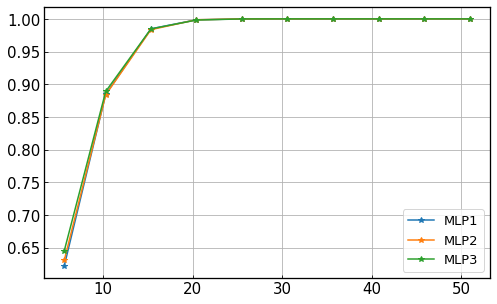

9.48997064347
[ 9.49652912  9.51696933  9.51058565]
MLP3
0.969029424239
[ 0.96916931  0.97044664  0.97059834]


In [10]:
AUC_fc_params = np.load('./AUC_data/AUC_OURs_new_ft_fc_params.npy')
snr_mf = np.load('./images/data/snr_mf_5fold.npy')
snr_mf_mean = snr_mf.mean(axis=1)

SNR_test_list = ['MLP2','MLP3',"MLP4"]
plt.figure(figsize=(8,5))
plt.plot(snr_mf_mean[2::2], AUC_OURs.mean(axis=2)[-1],'*-' ,label = 'MLP1')
for i in range(AUC_fc_params.shape[0])[:-1]:
    plt.plot(snr_mf_mean[2::2], AUC_fc_params.mean(axis=2)[i], '*-',label = SNR_test_list[i])
plt.legend(loc='lower right')
plt.grid()
if input('Save or not? (y/n)') == 'y':
    save_address = './images/'
    plt.savefig(save_address + 'fine_tune_num_MLPlayers.eps', dpi = 300, bbox_inches = 'tight')
    plt.savefig(save_address + 'fine_tune_num_MLPlayers.pdf', dpi = 300, bbox_inches = 'tight')
    print('Saved in '+save_address+'fine_tune_num_MLPlayers.eps')
else:
    pass

plt.show()
print(AUC_OURs.mean(axis=2)[-1].sum())
print(AUC_fc_params.mean(axis=2).sum(axis=1))
print('MLP3')
print(scipy.integrate.simps(AUC_OURs.mean(axis=2)[-1],snr_mf_mean[2::2])/scipy.integrate.simps(np.ones(10),snr_mf_mean[2::2]))
print(scipy.integrate.simps( AUC_fc_params.mean(axis=2),snr_mf_mean[2::2])/scipy.integrate.simps(np.ones(10),snr_mf_mean[2::2]))

## Fine-tune number of MLP neurals

Save or not? (y/n)y
Saved in ./images/fine_tune_num_MLPneurals.eps


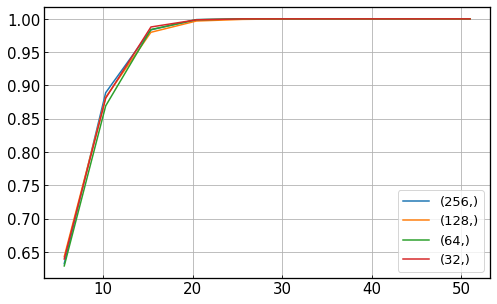

[ 9.50397643  9.50099077  9.48092033  9.50660492  5.        ]
256
[ 0.96989228  0.96878988  0.96748828  0.96967137  0.5       ]


In [11]:
AUC_num_filter = np.load('./AUC_data/AUC_OURs_new_ft_hidden_dim.npy')
snr_mf = np.load('./images/data/snr_mf_5fold.npy')
snr_mf_mean = snr_mf.mean(axis=1)

SNR_test_list =[(16*2**i,) for i in range(4+1)[::-1]] 
plt.figure(figsize=(8,5))
for i in range(AUC_num_filter.shape[0])[:-1]:
    plt.plot(snr_mf_mean[2::2],AUC_num_filter.mean(axis=2)[i], label = SNR_test_list[i])
plt.legend(loc='lower right')
plt.grid()
if input('Save or not? (y/n)') == 'y':
    save_address = './images/'
    plt.savefig(save_address + 'fine_tune_num_MLPneurals.eps', dpi = 300, bbox_inches = 'tight')
    plt.savefig(save_address + 'fine_tune_num_MLPneurals.pdf', dpi = 300, bbox_inches = 'tight')
    print('Saved in '+save_address+'fine_tune_num_MLPneurals.eps')
else:
    pass

plt.show()
print(AUC_num_filter.mean(axis=2).sum(axis=1))
print('256')
print(scipy.integrate.simps( AUC_num_filter.mean(axis=2),snr_mf_mean[2::2])/scipy.integrate.simps(np.ones(10),snr_mf_mean[2::2]))

## Fine-tune dropout of MLP

Save or not? (y/n)y
Saved in ./images/fine_tune_dropout.eps


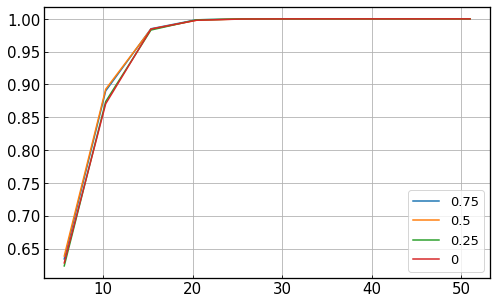

[ 9.50789647  9.51343376  9.4789106   9.48078055]
0.5
[ 0.97020971  0.97053038  0.96765793  0.96753647]


In [12]:
AUC_dropout = np.load('./AUC_data/AUC_OURs_new_dropout.npy')
snr_mf = np.load('./images/data/snr_mf_5fold.npy')
snr_mf_mean = snr_mf.mean(axis=1)

SNR_test_list =[0.75,0.5,0.25,0]
plt.figure(figsize=(8,5))
for i in range(AUC_dropout.shape[0]):
    plt.plot(snr_mf_mean[2::2], AUC_dropout.mean(axis=2)[i], label = SNR_test_list[i])
plt.legend(loc='lower right')
plt.grid()
if input('Save or not? (y/n)') == 'y':
    save_address = './images/'
    plt.savefig(save_address + 'fine_tune_dropout.eps', dpi = 300, bbox_inches = 'tight')
    plt.savefig(save_address + 'fine_tune_dropout.pdf', dpi = 300, bbox_inches = 'tight')
    print('Saved in '+save_address+'fine_tune_dropout.eps')
else:
    pass

plt.show()
print(AUC_dropout.mean(axis=2).sum(axis=1))
print('0.5')
print(scipy.integrate.simps( AUC_dropout.mean(axis=2),snr_mf_mean[2::2])/scipy.integrate.simps(np.ones(10),snr_mf_mean[2::2]))

## Fine-tune type of activation

Save or not? (y/n)y
Saved in ./images/fine_tune_type_activation.eps


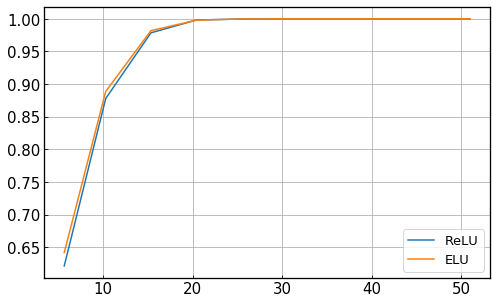

[ 9.47579615  9.51017908]
ELU
[ 0.96747981  0.96993509]


In [13]:
AUC_act = np.load('./AUC_data/AUC_OURs_new_ft_act_type.npy')
snr_mf = np.load('./images/data/snr_mf_5fold.npy')
snr_mf_mean = snr_mf.mean(axis=1)

SNR_test_list = ['ReLU','ELU']
plt.figure(figsize=(8,5))
for i in range(AUC_act.shape[0]):
    plt.plot(snr_mf_mean[2::2],AUC_act.mean(axis=2)[i], label = SNR_test_list[i])
plt.legend(loc='lower right')
plt.grid()
if input('Save or not? (y/n)') == 'y':
    save_address = './images/'
    plt.savefig(save_address + 'fine_tune_type_activation.eps', dpi = 300, bbox_inches = 'tight')
    plt.savefig(save_address + 'fine_tune_type_activation.pdf', dpi = 300, bbox_inches = 'tight')
    print('Saved in '+save_address+'fine_tune_type_activation.eps')
else:
    pass

plt.show()
print(AUC_act.mean(axis=2).sum(axis=1))
print('ELU')
print(scipy.integrate.simps( AUC_act.mean(axis=2),snr_mf_mean[2::2])/scipy.integrate.simps(np.ones(10),snr_mf_mean[2::2]))

## Fine-tune number of feature maps

Save or not? (y/n)y
Saved in ./images/fine_tune_num_featuremaps.eps


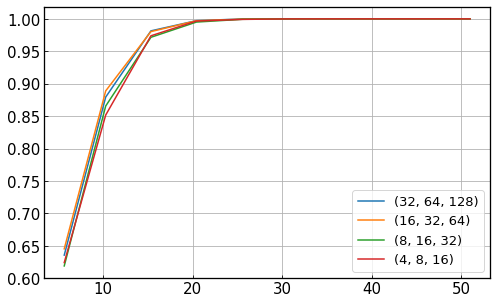

[ 9.49380106  9.51144436  9.45066563  9.44558299]
(16,32,64)
[ 0.96848059  0.96980926  0.96476956  0.96379359]


In [14]:
AUC_num_filter = np.load('./AUC_data/AUC_OURs_new_ft_num_filter.npy')
snr_mf = np.load('./images/data/snr_mf_5fold.npy')
snr_mf_mean = snr_mf.mean(axis=1)

SNR_test_list = [(4*2**(i), 8*2**(i), 16*2**(i)) for i in range(1+3)[::-1]]
plt.figure(figsize=(8,5))
for i in range(AUC_num_filter.shape[0]):
    plt.plot(snr_mf_mean[2::2],AUC_num_filter.mean(axis=2)[i], label = SNR_test_list[i])
plt.legend(loc='lower right')
plt.grid()
if input('Save or not? (y/n)') == 'y':
    save_address = './images/'
    plt.savefig(save_address + 'fine_tune_num_featuremaps.eps', dpi = 300, bbox_inches = 'tight')
    plt.savefig(save_address + 'fine_tune_num_featuremaps.pdf', dpi = 300, bbox_inches = 'tight')
    print('Saved in '+save_address+'fine_tune_num_featuremaps.eps')
else:
    pass

plt.show()
print(AUC_num_filter.mean(axis=2).sum(axis=1))
print('(16,32,64)')
print(scipy.integrate.simps( AUC_num_filter.mean(axis=2),snr_mf_mean[2::2])/scipy.integrate.simps(np.ones(10),snr_mf_mean[2::2]))

## Fine-tune dialution

Save or not? (y/n)y
Saved in ./images/fine_tune_dialute.eps


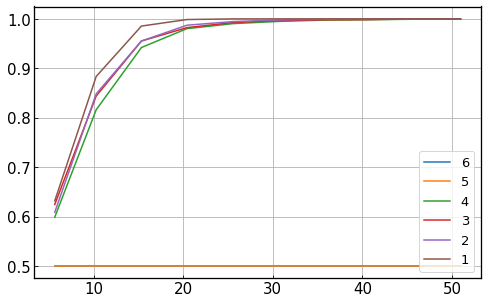

[ 5.          5.          9.31661532  9.39063416  9.38997133  9.49896709]
1
[ 0.5         0.5         0.9510241   0.9576048   0.95864252  0.96937142]


In [15]:
AUC_dialution = np.load('./AUC_data/AUC_OURs_new_ft_dialute.npy')
snr_mf = np.load('./images/data/snr_mf_5fold.npy')
snr_mf_mean = snr_mf.mean(axis=1)

SNR_test_list = [6,5,4,3,2,1]
plt.figure(figsize=(8,5))
for i in range(AUC_dialution.shape[0]):
    plt.plot(snr_mf_mean[2::2],AUC_dialution.mean(axis=2)[i], label = SNR_test_list[i])
plt.legend(loc='lower right')
plt.grid()
if input('Save or not? (y/n)') == 'y':
    save_address = './images/'
    plt.savefig(save_address + 'fine_tune_dialute.eps', dpi = 300, bbox_inches = 'tight')
    plt.savefig(save_address + 'fine_tune_dialute.pdf', dpi = 300, bbox_inches = 'tight')
    print('Saved in '+save_address+'fine_tune_dialute.eps')
else:
    pass

plt.show()
print(AUC_dialution.mean(axis=2).sum(axis=1))
print('1')
print(scipy.integrate.simps( AUC_dialution.mean(axis=2),snr_mf_mean[2::2])/scipy.integrate.simps(np.ones(10),snr_mf_mean[2::2]))

## Fine-tune pooling layers

Save or not? (y/n)y
Saved in ./images/fine_tune_poolinglayer.eps


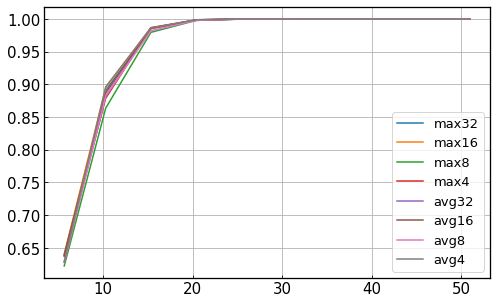

[ 9.51123692  9.51990706  9.46267845  9.49960886  9.49421431  9.5098596
  9.48872703  9.50897078]
max16
[ 0.97029078  0.97113486  0.96589067  0.96904729  0.96898515  0.9700708
  0.96852877  0.97078027]


In [16]:
AUC_pool_params = np.load('./AUC_data/AUC_OURs_new_ft_pool_params.npy')
snr_mf = np.load('./images/data/snr_mf_5fold.npy')
snr_mf_mean = snr_mf.mean(axis=1)

SNR_test_list = ['max32', 'max16','max8','max4', 'avg32', 'avg16','avg8', 'avg4']
plt.figure(figsize=(8,5))
for i in range(AUC_pool_params.shape[0]):
    plt.plot(snr_mf_mean[2::2],AUC_pool_params.mean(axis=2)[i], label = SNR_test_list[i])
plt.legend(loc='lower right')
plt.grid()
if input('Save or not? (y/n)') == 'y':
    save_address = './images/'
    plt.savefig(save_address + 'fine_tune_poolinglayer.eps', dpi = 300, bbox_inches = 'tight')
    plt.savefig(save_address + 'fine_tune_poolinglayer.pdf', dpi = 300, bbox_inches = 'tight')
    print('Saved in '+save_address+'fine_tune_poolinglayer.eps')
else:
    pass
plt.show()
print(AUC_pool_params.mean(axis=2).sum(axis=1))
print('max16')
print(scipy.integrate.simps( AUC_pool_params.mean(axis=2),snr_mf_mean[2::2])/scipy.integrate.simps(np.ones(10),snr_mf_mean[2::2]))

## Fine-tune convlution layers

Save or not? (y/n)y
Saved in ./images/fine_tune_num_convlayers.eps


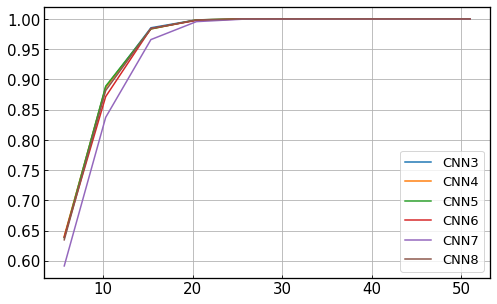

[ 9.50870621  9.50873915  9.50832886  9.49165511  9.38912063  9.49811966]
CNN3
[ 0.96997804  0.96983758  0.96998255  0.96799634  0.95972352  0.96906142]


In [17]:
AUC_conv_params = np.load('./AUC_data/AUC_OURs_new_ft_conv_params.npy')
snr_mf = np.load('./images/data/snr_mf_5fold.npy')
snr_mf_mean = snr_mf.mean(axis=1)

label_list = ['CNN3','CNN4','CNN5','CNN6','CNN7','CNN8']
plt.figure(figsize=(8,5))
for i in range(AUC_conv_params.shape[0]):
    plt.plot(snr_mf_mean[2::2],AUC_conv_params.mean(axis=2)[i], label = label_list[i])
plt.legend(loc='lower right')
plt.grid()
if input('Save or not? (y/n)') == 'y':
    save_address = './images/'
    plt.savefig(save_address + 'fine_tune_num_convlayers.eps', dpi = 300, bbox_inches = 'tight')
    plt.savefig(save_address + 'fine_tune_num_convlayers.pdf', dpi = 300, bbox_inches = 'tight')
    print('Saved in '+save_address+'fine_tune_num_convlayers.eps')
else:
    pass
plt.show()
print(AUC_conv_params.mean(axis=2).sum(axis=1))
print('CNN3')
print(scipy.integrate.simps( AUC_conv_params.mean(axis=2),snr_mf_mean[2::2])/scipy.integrate.simps(np.ones(10),snr_mf_mean[2::2]))

Save or not? (y/n)y
Saved in ./images/model_compare.eps


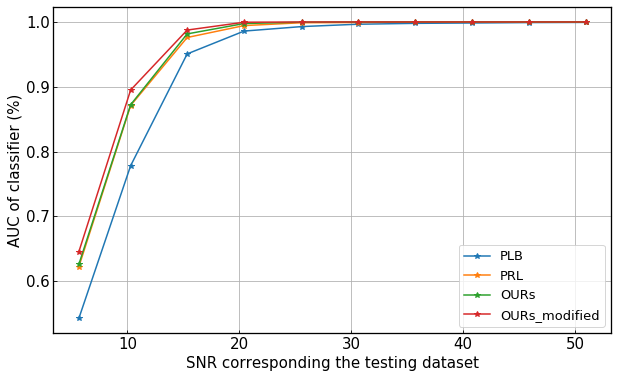

In [19]:
AUC_PRL = np.load('./AUC_data/AUC_PRL_new2.npy')
AUC_PLB = np.load('./AUC_data/AUC_PLB_new2.npy')
AUC_PLB = AUC_PLB[:,1::2,:][:,::-1,:]
AUC_OURs = np.load('./AUC_data/AUC_OURs_new2.npy')
AUC_OURs_modified = np.load('./AUC_data/AUC_OURs_modified.npy')

snr_mf = np.load('./images/data/snr_mf_5fold.npy')
snr_mf_mean = snr_mf.mean(axis=1)

plt.figure(figsize=(10,6))
plt.plot(snr_mf_mean[2::2], AUC_PLB.mean(axis=2)[0] , '*-',label = 'PLB')
plt.plot(snr_mf_mean[2::2], AUC_PRL.min(axis=2)[0] , '*-' ,label = 'PRL')
plt.plot(snr_mf_mean[2::2], AUC_OURs.min(axis=2)[0] , '*-',label = 'OURs')
plt.plot(snr_mf_mean[2::2], AUC_OURs_modified.max(axis=2)[0] , '*-',label = 'OURs_modified')
# plt.plot(AUC_PLB.mean(axis=2)[AUC_PLB.mean(axis=2).sum(axis=1).argmax()] ,label = 'PLB_max')
# plt.plot(AUC_PRL.mean(axis=2)[AUC_PRL.mean(axis=2).sum(axis=1).argmax()] ,label = 'PRL_max')
# plt.plot(AUC_OURs.mean(axis=2)[AUC_OURs.mean(axis=2).sum(axis=1).argmax()] ,label = 'OURs_max')
plt.ylabel('AUC of classifier (%)')
plt.xlabel('SNR corresponding the testing dataset')
plt.grid()
plt.legend(loc=4)
if input('Save or not? (y/n)') == 'y':
    save_address = './images/'
    plt.savefig(save_address + 'model_compare.eps', dpi = 300, bbox_inches = 'tight')
    plt.savefig(save_address + 'model_compare.pdf', dpi = 300, bbox_inches = 'tight')
    print('Saved in '+save_address+'model_compare.eps')
else:
    pass
plt.show()
# plt.xlim(0, 3)

In [ ]:
AUC_PRL = np.load('./AUC_data/AUC_PRL_new2.npy')
AUC_PLB = np.load('./AUC_data/AUC_PLB_new2.npy')
AUC_PLB = AUC_PLB[:,1::2,:][:,::-1,:]
AUC_OURs = np.load('./AUC_data/AUC_OURs_new2.npy')
AUC_OURs_modified = np.load('./AUC_data/AUC_OURs_modified.npy')
# AUC_OURs_2localnoise1 = np.load('./AUC_data/AUC_OURs_2localnoise1.npy')
# AUC_OURs_2localnoise5 = np.load('./AUC_data/AUC_OURs_2localnoise5.npy')
# AUC_OURs_2localnoise10 = np.load('./AUC_data/AUC_OURs_2localnoise10.npy')
# AUC_OURs_new3_localnoise = np.load('./AUC_data/AUC_OURs_new3_localnoise.npy')

# https://stackoverflow.com/questions/41806066/families-of-curves-with-different-seaborn-palettes-in-one-plot
snr_mf = np.load('./images/data/snr_mf_5fold.npy')
snr_mf_mean = snr_mf.mean(axis=1)

fig, ax = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(10)



df = pd.DataFrame(AUC_PRL.mean(axis=2), index = ['$SNR_{MF}$=%.2f' %snr for snr in snr_mf_mean[2::2]][::-1], columns=SNR_test_list[::-1])
for i in range(AUC_PRL.shape[0]):
    df.T.plot(marker= '*',linestyle=':', ax=ax, color=sns.color_palette('Greens', 13), alpha = 1)    
    
df = pd.DataFrame(AUC_PLB.mean(axis=2), index = ['$SNR_{MF}$=%.2f' %snr for snr in snr_mf_mean[2::2]][::-1], columns=SNR_test_list[::-1])
for i in range(AUC_PLB.shape[0]):
    df.T.plot(marker= '*',linestyle=':', ax=ax, color=sns.color_palette('Blues', 13), alpha = 1)    

df = pd.DataFrame(AUC_OURs.mean(axis=2), index = ['$SNR_{MF}$=%.2f' %snr for snr in snr_mf_mean[2::2]][::-1], columns=SNR_test_list[::-1])    
for i in range(AUC_OURs.shape[0]):
    df.T.plot(marker= '*', ax=ax, color=sns.color_palette("Oranges", 10), alpha = 1)    

ax.legend(ncol=2, loc='best')
# ax.set_xlim(0.09, 1.01)
# ax.set_ylabel('AUC of classifier (%)')
# ax.set_xlabel('SNR corresponding the testing dataset')
# ax.grid()
# if input('Save or not? (y/n)') == 'y':
#     save_address = './images/'
#     plt.savefig(save_address + 'AUC_comparison_training.eps', dpi = 300, bbox_inches = 'tight')
#     plt.savefig(save_address + 'AUC_comparison_training.pdf', dpi = 300, bbox_inches = 'tight')
#     print('Saved in '+save_address+'AUC_comparison_training.eps')
# else:
#     pass
plt.show()